In [1]:
from FireBotMAP import Map_generator
import numpy as np
import matplotlib.pyplot as plt
import yaml
from PIL import Image
from FireBot_path_optimizer import WayPointOptimizer

import csv
import os

In [2]:
from path_generator import calculate_and_plot_path

In [3]:
root_dir = "/home/skachavarapu/home/Research_Track/house_ipa_results"

In [4]:
file_path = '/home/skachavarapu/home/Research_Track/TPSA/warehouse/fov_90_new/wp_ori_data.txt'
with open(file_path, 'r') as f:
    lines = f.readlines()
    wp = eval(lines[0].split('=')[1].strip())
    ori = eval(lines[1].split('=')[1].strip())

In [5]:
goals = wp

In [7]:
optimized_goals = WayPointOptimizer(goals, 0.3, 5)
goals1 = optimized_goals.run()

In [8]:
pgm_filename = "/home/skachavarapu/home/Research_Track/house_ipa_results/map.pgm"
yaml_filename = "/home/skachavarapu/home/Research_Track/house_ipa_results/map.yaml"
map_generator = Map_generator()
grid = map_generator.load_pgm(pgm_filename)

yaml_data = map_generator.load_yaml(yaml_filename)

In [9]:
def load_pgm(pgm_path):
        with Image.open(pgm_path) as img:
            return np.array(img)

In [10]:
import numpy as np
def heuristic(a, b):
    """Calculate the Manhattan distance between two points."""
    return abs(a[0] - b[0]) + abs(a[1] - b[1])
def a_star(map_data, start, goal, free_space=[254], buffer_radius=1):
    neighbors = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # 4-way connectivity
    open_set = {start}
    came_from = {}
    
    g_score = {start: 0}
    f_score = {start: heuristic(start, goal)}
    
    while open_set:
        current = min(open_set, key=lambda x: f_score.get(x, np.inf))
        
        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)  # Optional: include start in path
            return path[::-1]  # Return reversed path
        
        open_set.remove(current)
        for dx, dy in neighbors:
            neighbor = (current[0] + dx, current[1] + dy)
            
            # Check if within bounds and navigable with buffer clearance
            if is_navigable(map_data, neighbor, free_space, buffer_radius):
                tentative_g_score = g_score[current] + 1  # Cost = 1 per step
                
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                    open_set.add(neighbor)
    
    return []  # Return empty path if no path found

def is_navigable(map_data, cell, free_space, buffer_radius):
    """
    Check if a cell and its surrounding cells (within buffer_radius) are free.
    """
    x, y = cell
    for dx in range(-buffer_radius, buffer_radius + 1):
        for dy in range(-buffer_radius, buffer_radius + 1):
            nx, ny = x + dx, y + dy
            if not (0 <= nx < map_data.shape[0] and 0 <= ny < map_data.shape[1]):
                return False  # Out of bounds
            if map_data[nx, ny] not in free_space:
                return False  # Obstacle detected within buffer area
    return True

def connect_goals(map_data, goals, free_space=[254], buffer_radius=1):
    """
    Connect all goals in a closed loop considering robot footprint.
    If no path is possible between consecutive goals, attempt to skip to the next goal.
    """
    full_path = []
    
    for i in range(len(goals)):
        start = goals[i]
        for j in range(i + 1, len(goals)):
            goal = goals[j]
            path = a_star(map_data, start, goal, free_space, buffer_radius)
            
            if path:  # If a valid path is found
                full_path.extend(path)
                break  # Move to the next set of goals
    
    return full_path





In [29]:
# Example usage:
goals1 = [(350, 67), (315, 102), (311, 102), (295, 108), (310, 152), 
          (317, 152), (327, 154), (343, 247), (331, 251), (308, 297), 
          (320, 335), (310, 373), (300, 371), (287, 420), (225, 431), 
          (233, 408), (198, 384), (229, 349), (274, 379), (271, 337), 
          (270, 331), (274, 313), (231, 299), (162, 330), (153, 290), 
          (145, 215), (183, 228), (185, 228), (193, 258), (208, 254), 
          (242, 265), (259, 215), (234, 210), (222, 185), (273, 177), 
          (269, 164), (253, 129), (219, 98), (207, 68), (278, 77), (350, 67)]


goals = [
    (350, 67),
    (315, 102),
    (317, 152),
    (273, 177),
    (234, 210),
    (208, 254),
    (231, 299),
    (270, 331),
    (300, 371),
    (308, 297),
    (253, 129),
    (274, 379),
    (193, 258),
    (331, 251),
    (233, 408),
    (310, 373),
    (242, 265),
    (295, 108),
    (259, 215),
    (183, 228),
    (153, 290),
    (229, 349),
    (219, 98),
    (327, 154),
    (222, 185),
    (269, 164),
    (225, 431),
    (271, 337),
    (162, 330),
    (274, 313),
    (145, 215),
    (207, 68),
    (310, 152),
    (343, 247),
    (320, 335),
    (311, 102),
    (278, 77),
    (198, 384),
    (185, 228),
    (287, 420)
]


In [11]:
def convert_pgm_to_binary_custom(image_array):
    """
    Convert a .pgm file to a binary .png file where value 254 is converted to white (255)
    and all other values to black (0).

    Parameters:
    - pgm_file_path: str, path to the .pgm file
    - png_file_path: str, path where the .png file will be saved
    """
    # Load the PGM file
   

    # Convert value 254 to white (255), and all other values to black (0)
    binary_image_array = np.where(image_array == 254, 255, 0).astype(np.uint8)

    # Convert the modified NumPy array back to an image
    binary_image = Image.fromarray(binary_image_array)    
    return binary_image

/tmp/ipykernel_1602198/2453477737.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


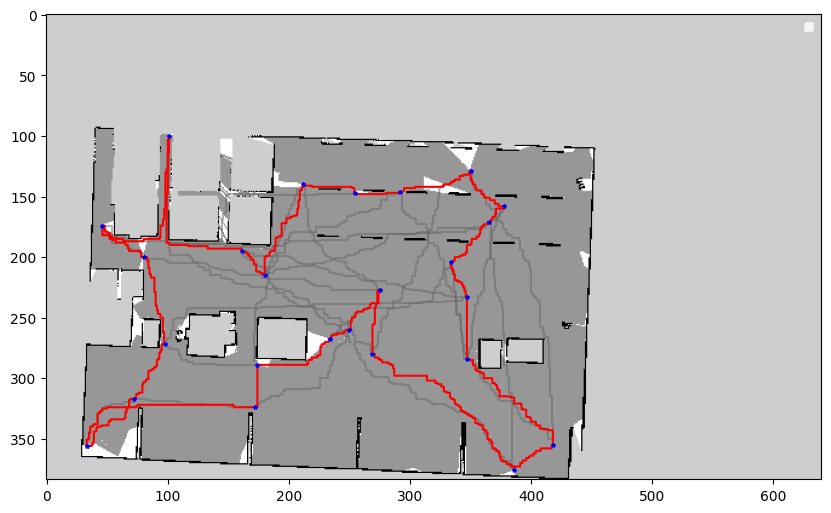

In [16]:
before_wpo = True
after_wpo = True
#goals1 = best_path
total_path_length = 0
total_path_length1 = 0
buffer_radius = 1
fig, ax = plt.subplots(figsize=(10, 10))
#b_map = convert_pgm_to_binary_custom(map_data)
#cummulative_rotation = 574
area_map = load_pgm('area.pgm')
map_data = grid
ax.imshow(area_map, cmap='gray')
grid1 = np.copy(map_data)
grid2= np.copy(map_data)

if before_wpo:
    for i in range(len(goals) - 1):
        path = a_star(grid1, goals[i], goals[i+1])
        if path:
            
            #total_path_length += len(path) * resolution
            
            y, x = zip(*path)
            ax.plot(x, y, color='dimgray', alpha = 0.5)  
if after_wpo:
    path1 = connect_goals(grid2, goals1, buffer_radius=buffer_radius)
    if path1:
        
        #total_path_length1 += len(path1) * resolution
        
        y1, x1 = zip(*path1)
        ax.plot(x1, y1, color='r')


# Plotting goals
for goal in goals1:
    ax.plot(goal[1], goal[0], 'b*', markersize=3)
 
#t_t = revisit_time_(total_path_length1, cummulative_rotation, linear_speed = 0.3, rotational_speed= 0.52)
#print(f'path_length {total_path_length1},cummulative rotations {cummulative_rotation}, revisit_time {t_t}')
#metrics = ['path_length',total_path_length1,'cummulative rotations',cummulative_rotation, 'revisit_time' ,t_t]
#csv_file = 'latest_results_3/ipa.csv'
#with open(csv_file,'w',newline = '') as file:
 #   writer = csv.writer(file)
  #  writer.writerow(metrics)
plt.legend()
plt.savefig('latest_results_3/warehouse_before_and_after_wpo_updated.png', dpi=200) 
plt.show()